# 3. Temporal Difference Learning Introduction.

---
* **Author**: Juan Esteban Cepeda Baena.
* **Linkedin**: https://www.linkedin.com/in/juan-e-cepeda-gestion/
* **Email**: juancepeda.gestion@gmail.com / jecepedab@unal.edu.co
* **Google Site**: https://sites.google.com/view/juancepeda/
* **Code License**: NonCommercial. **If you are going to use my code, please put a link to my github's profile.**
---

I highly recommend to visit the David Silver Lectures on Temporal Difference Reinforcement Learning: https://www.youtube.com/watch?v=PnHCvfgC_ZA&t


The Temporal Difference is class of model-free reinforcement learning method. Even though these methods learn directly from experiencie (trial and error) as explained in the MonteCarlo section, its difference with MonteCarlo is based on the fact that they don't have to wait until the end of an episode. Instead, they can update the action-value function after each step of the episode. In its most basic form, a TD algorithm uses the following formula to perform a state-value update:

$V(S_{t}) = V(S_{t}) + \alpha [r_{t+1} + \gamma V(S_{t+1}) - V{S_{t}}]$

Where $\alpha$ is called step size (learning rate) and it's in the range of $[0, 1]$.

In this notebook, we first consider the problem of the policy evaluation using temporal difference learning, then, we continue with policy control.

<img src = "./imagenes/temporal_difference_backup.png" width = "500px" height = "450px">

### 1. Policy Evaluation (Prediction) for Temporal Difference Learning.

<img src = "./imagenes/temporal_difference_policy_evaluation_algorithm.png" width = "650px">

In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [2]:
class Graphics():
    
    def __init__(self):
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]
        
    def render(self, position, value_state_table, plot_values = True):
            
        fig1 = plt.figure(figsize=(4, 4))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

         # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.2, 0.8), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))
        
        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.4), 0.2, 0.2, facecolor = "#33A4FF"))
        
        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot player.
        plt.scatter(self.grid_pos[position[0]], self.grid_pos[position[1]], s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        if plot_values:
            for i in range(0, len(value_state_table)):
                for j in range(0, len(value_state_table[0])):
                    plt.text(self.grid_pos[i] - 0.08, self.grid_pos[j] - 0.03, 
                             round(value_state_table[i][j], 1), fontsize=10)
                
        # Plot grid.
        plt.axis("off")
        plt.show()  

In [3]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1]]
        self.rewards = [[self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw]]

In [4]:
class modelFreeAgent():
    
    def __init__(self, policy, discount_factor):
        self.pos = [0,0]
        self.total_reward = 0
        self.discount_factor = discount_factor
        self.actions = ["up", "down", "left", "right"]
        
        # Start with a random policy. 0.25 chance of moving to any direction.
        self.policy = policy   
        
    # Move!
    def move(self, environment):
    
        # Select action according to policy.
        action = self.policy[self.pos[0]][self.pos[1]]
        if action == "r":
            action = self.actions[random.randint(0, 3)]

        # Move to new position according to action taken.
        self.pos = self.forwardState(self.pos, action, environment)
        
    # Select action according to policy.
    def selectAction(self, state):
        
        if(self.policy[state[0]][state[1]] == "r"):
            action = self.actions[random.randint(0, len(self.available_actions) - 1)] # Agent initial policy.
        else: 
            action = self.policy[state[0]][state[1]]
        return action
            
    def forwardState(self, pos, action, environment):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(environment.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]
        elif(action == "down" and pos[1] > 0):
            if(environment.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]
        elif(action == "left" and pos[0] > 0):
            if(environment.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]
        elif(action == "right" and pos[0] < 4):
            if(environment.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position

    def getPosition(self):
        return self.pos
    
    def getReward(self):
        return self.total_reward
    
    def setPosition(self, x, y):
        self.pos = [x, y]

In [5]:
class PolicyEvaluation(Graphics):
    
    def __init__(self, environment, agent, ephocs = 10, learning_rate = 0.5):

        # Print message!
        print("Policy Evaluation Initialized!")
        
        # Initialize environment & agent.
        self.environment = environment       
        self.agent = agent      
        
        # Set ephocs, initialize graphics object & set update method.
        self.ephocs = ephocs
        self.graphics = Graphics()
        
        # Initialize value state table.
        self.value_state_table = [[0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 100, 0]]
        
        # Set learning rate.
        self.learning_rate = learning_rate
        self.steps = 0
        
    def render(self):
        self.graphics.render(self.agent.pos, self.value_state_table)
    
    def temporal_difference_policy_evaluation(self, velocity = 0.05, plot_ephocs = True):
        
        # Generate k ephocs.
        for k in range(0, self.ephocs):
            
            # Continue until get to the terminal state.
            while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
                
                # Previous position.
                pre = self.agent.pos.copy()
                
                # Move the player.
                self.agent.move(self.environment)
                
                # Compute TD target.
                reward = self.environment.rewards[self.agent.pos[0]][self.agent.pos[1]]
                new_state_value = self.value_state_table[self.agent.pos[0]][self.agent.pos[1]]
                TD_target = reward + self.agent.discount_factor * new_state_value
                
                # Compute TD error.
                TD_error = TD_target - self.value_state_table[pre[0]][pre[1]]
                
                # Update value state table.
                self.value_state_table[pre[0]][pre[1]] = (self.value_state_table[pre[0]][pre[1]] +
                                                         self.learning_rate * (TD_error))
                
                # Method of the super class.
                if(plot_ephocs):

                    # Render game.
                    self.render()
                    time.sleep(velocity)
                    clear_output(wait = True)
                    
            # Set agent position.
            positions = [(0,0), (1, 4), (4, 1)]
            initial_state = positions[k % 3]
            self.agent.setPosition(initial_state[0], initial_state[1])

In [6]:
class Game():
    
    def __init__(self, environment, agent, value_state_table):
        
        self.environment = environment       
        self.agent = agent
        self.graphics = Graphics()
        self.table = value_state_table
        
    def update(self, secs, plot_values = False):
        
        pos = self.agent.getPosition()
        self.graphics.render(pos, self.table, plot_values)
        time.sleep(1)
        clear_output(wait = True)
        
        while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
            
            # Move to the next state according to policy.
            self.agent.move(self.environment)
            
            # Get new agent position.
            pos = self.agent.getPosition()
            
            # Render the game.
            self.render(pos, self.table, plot_values)
            time.sleep(secs)
            clear_output(wait = True)

#### 1.1 Policy Evaluation - Temporal Difference Learning, TD(0)

Policy Evaluation Initialized!


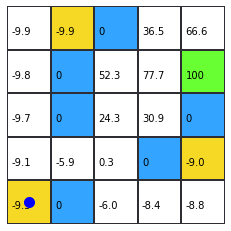

In [10]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)

# Initialize environment and agent.
discount_factor = 0.9
environment = GridEnvironment()
agent = modelFreeAgent(policy, discount_factor)

# Initialize policy evaluation class.
ephocs = 10000
learning_rate = 0.5
policy_evaluation = PolicyEvaluation(environment, agent, ephocs, learning_rate)
policy_evaluation.temporal_difference_policy_evaluation(velocity = 0.01, plot_ephocs = False)
policy_evaluation.render()

## TD(n).

---

In the previous example, we updated our value function table after observing what happened one step in the future, however, we could have done the same after considering $n$-steps in the future, i.e, we can generalize this process as indicated in the image (we will incorporate this functionality in future versions of this notebook):

<img src = "./imagenes/n_step_return_temporal_difference_learning.png" width = "400px" >

## TD($\lambda$).

---

Another approach to compute the value function is to average the $n$-step returns. The natural question that arrises from the latter proposal is: Can we efficiently combine information from all time-steps? The answer is **Yes, we can**, using the TD($\lambda$) algorithm (we will incorporate this functionality in future versions of this notebook):

<img src = "./imagenes/lambda_return_temporal_difference.png" width = "500px" >
<img src = "./imagenes/forward_view_lamda_return_temporal_difference.png" width = "500px">

### 2. Policy Improvement (Control) for Temporal Difference Learning.

Great! Thanks to the preceding section, now we know how policy evaluation works for Temporal Difference Learning approach. Now, let's study the methods we can use to improve our policy.

First, suppose you are hired by a company to perform a specific job you have never done before. The manager of the company tells you that they don't have enough resources to train you properly in your new job, so you will have to learn everything by your own. According to this situation, is quite probable that once you start working you don't know what you have to do or what are the sequence of optimal actions, to complete a specific task. It might take you some time, but if you try again and again (trial and error) you will start learning how to perform your job sucessfully. This learning approach is know in reinforcement learning as **On-Policy Learning**, which means you learn **in the job**, and it is implemented by the **SARSA algorithm**, which we will study in sub-section 2.1.

Conversely to **On-Policy Learning**, we have **Off-Policy Learning**, which means you learn by **observation.** Let's go back to the preceding example where you are hired by a company, but this time the manager assigns one of her best employees to teach you how to complete your tasks. Hence, you will be observing for a couple of weeks how this person work, and then, once the teaching program has ended, you will be ready to work. This learning approach is implemented by the **Q-learning algorithm**, which we will study in sub-sction 2.2.

### 2.1 SARSA Control (On-policy). Improving our policy learning "in the job".

---
<img src = "./imagenes/sarsa_control_preview_algorithm.png" width = "400px" >

---
<img src = "./imagenes/sarsa_control_egreedy_algorithm.png" width = "500px">

---
<img src = "./imagenes/sarsa_control_preview2_algorithm.png" width = "400px">

In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [35]:
class Graphics():
    
    def __init__(self):
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]
        
    def render(self, position, q_value_table, plot_values = True):
            
        fig1 = plt.figure(figsize=(7, 7))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

         # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.2, 0.8), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))
        
        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.4), 0.2, 0.2, facecolor = "#33A4FF"))
        
        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot player.
        plt.scatter(self.grid_pos[position[0]], self.grid_pos[position[1]], s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        if plot_values:
            for i in range(0, len(q_value_table)):
                for j in range(0, len(q_value_table)):
                    
                    colors = ["black", "black", "black", "black"]
                    fontsize_ = [11, 11, 11, 11]
                    
                    q_values = list()
                    for action in range(0, 4):
                        q_values.append(q_value_table[i][j][action])
                    if not q_values == [0, 0, 0 ,0]:
                        best_q = max(q_values)
                        best_q = q_values.index(best_q)
                        colors[best_q] = "blue"
                        fontsize_[best_q] = 13
                 
                    # Up, bottom, left, right.
                    plt.text(i/5 + 0.075, j/5 + 0.15, round(q_value_table[i][j][0], 1), fontsize=fontsize_[0], c = colors[0])
                    plt.text(i/5 + 0.075, j/5 + 0.03, round(q_value_table[i][j][1], 1), fontsize=fontsize_[1], c = colors[1])
                    plt.text(i/5 + 0.01, j/5 + 0.085, round(q_value_table[i][j][2], 1), fontsize=fontsize_[2], c = colors[2])
                    plt.text(i/5 + 0.14, j/5 + 0.085, round(q_value_table[i][j][3], 1), fontsize=fontsize_[3], c = colors[3])
                
        # Plot grid.
        plt.axis("off")
        plt.show()  

In [36]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1]]
        self.rewards = [[self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, 10, self.rw]]

In [37]:
class modelFreeAgent():
    
    def __init__(self, policy, discount_factor):
        self.pos = [0,0]
        self.total_reward = 0
        self.discount_factor = discount_factor
        self.actions = ["up", "down", "left", "right"]
        
        # Start with a random policy. 0.25 chance of moving to any direction.
        self.policy = policy   
        
    # Move!
    def move(self, action, environment):
        # Move to new position according to action taken.
        self.pos = self.forwardState(self.pos, action, environment)
        
    # Take an action!
    def takeAction(self, epsilon):
        
        # Select action according to policy.
        action = self.policy[self.pos[0]][self.pos[1]]
        if action == "r":
            action = self.actions[random.randint(0, 3)]
        else:
            # Epsilon-greedy policy!
            num = random.randint(1, 100)
            if not num < (1 - epsilon + epsilon/len(self.actions)) * 100:
                action = self.actions[random.randint(0, 3)]
        return action
        
    # Get forward state.
    def forwardState(self, pos, action, environment):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(environment.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]
        elif(action == "down" and pos[1] > 0):
            if(environment.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]
        elif(action == "left" and pos[0] > 0):
            if(environment.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]
        elif(action == "right" and pos[0] < 4):
            if(environment.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position
    
    def getPosition(self):
        return self.pos.copy()
    
    def getReward(self):
        return self.total_reward
    
    def setPosition(self, x, y):
        self.pos = [x, y]
        
    def selectBestAction(self, value_state_table, environment):
        
        go_up = self.forwardState(self.pos, "up", environment)
        go_down = self.forwardState(self.pos, "down", environment)
        go_left = self.forwardState(self.pos, "left", environment)
        go_right = self.forwardState(self.pos, "right", environment)
        
        up_value = value_state_table[go_up[0]][go_up[1]]
        down_value = value_state_table[go_down[0]][go_down[1]]
        left_value = value_state_table[go_left[0]][go_left[1]]
        right_value = value_state_table[go_right[0]][go_right[1]]
        values = [up_value, down_value, left_value, right_value]
        
        best_action = self.actions[values.index(max(values))] 
        return best_action       

In [41]:
class PolicyControl():
    
    # Initialize policy control object.
    def __init__(self, environment, agent, epsilon = 0.2, ephocs = 10, learning_rate = 0.5):
        
        # Print message!
        print("Policy Control Initialize!")
        
        # Initialize environment & agent.
        self.environment = environment       
        self.agent = agent     
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        
        # Set ephocs and initialize graphics object.
        self.ephocs = ephocs
        self.graphics = Graphics()
        
        # Generate Q value table.
        self.q_value_table = list()
        for i in range(0, 5):
            column = list()
            for j in range(0, 5):
                column.append([0, 0, 0, 0])
            self.q_value_table.append(column)
                
    # Montecarlo control algorithm.
    def sarsa_control(self, velocity = 0.05, plot_ephocs = True, plot_evaluation = True):

        # Repeat k ephocs.
        for k in range(0, self.ephocs):
            
            # Continue until get to the terminal state.
            while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
                
                # Current position.   
                current_pos = self.agent.pos.copy()                                           # S

                # Take an action according to the agent policy. 
                action = self.agent.takeAction(self.epsilon)                                  # A
                
                # Compute new state and reward recieve. 
                new_position = self.agent.forwardState(current_pos, action, self.environment) # R
                reward_recieved = self.environment.rewards[new_position[0]][new_position[1]]  # S
                
                # Move the player.
                self.agent.move(action, self.environment)
                
                # Select new action.
                action2 = self.agent.takeAction(self.epsilon)                                 # A'
                
                # Render Q-value update.
                if(plot_ephocs):
                    self.render()
                    time.sleep(velocity)
                    clear_output(wait = True)
                
                # Get Q-values from table.
                z_index = self.agent.actions.index(action)
                q_value_sa = self.q_value_table[current_pos[0]][current_pos[1]][z_index]
                z_index_prime = self.agent.actions.index(action2)
                q_value_sa_prime = self.q_value_table[self.agent.pos[0]][self.agent.pos[1]][z_index_prime]
                
                # Get SARA target.
                SARSA_target = reward_recieved + self.agent.discount_factor * q_value_sa_prime

                # Compute SARSA error.
                SARSA_error = SARSA_target - q_value_sa

                # Update Q-value table.
                self.q_value_table[current_pos[0]][current_pos[1]][z_index] += self.learning_rate * (SARSA_error)

                # Update e-greedy policy???
                self.update_egreedy_policy(current_pos[0], current_pos[1])
                
            # Change agent position.
            positions = [(0,0), (4, 1), (1, 4)]
            pos = positions[k % 3]
            self.agent.setPosition(pos[0], pos[1])
                
    def render(self):
        self.graphics.render(self.agent.pos, self.q_value_table)
    
    # Update egreedy policy.
    def update_egreedy_policy(self, x, y):
        q_values = list()
        for action in range(0, 4):
            q_values.append(self.q_value_table[x][y][action])
        if not q_values == [0, 0, 0, 0]:
            
            # Epsilon-greedy improvement.
            num = random.randint(1, 100)
            if not num < (1 - self.epsilon + self.epsilon/len(self.agent.actions)) * 100:
                q_values.remove(max(q_values))
                action = self.agent.actions[q_values.index(random.choice(q_values))]
            else:
                best_q = max(q_values)
                best_q = q_values.index(best_q)
                self.agent.policy[x][y] = self.agent.actions[best_q]

In [42]:
class Game():
    
    def __init__(self, environment, agent, value_state_table):
        
        self.environment = environment       
        self.agent = agent
        self.graphics = Graphics()
        self.table = q_value_table
        
    def update(self, secs, plot_values = False):
        
        pos = self.agent.getPosition()
        self.graphics.render(pos, self.table, plot_values)
        time.sleep(1)
        clear_output(wait = True)
        
        while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
            
            # Select action according to greedy policy (epsilon = 0)
            action = self.agent.takeAction(epsilon = 0.05)
            
            # Move agent.
            self.agent.move(action, self.environment)
            
            # Get new agent position.
            pos = self.agent.getPosition()
            
            # Render game.
            self.graphics.render(pos, self.table, plot_values)
            time.sleep(secs)
            clear_output(wait = True)

Policy Control Initialize!


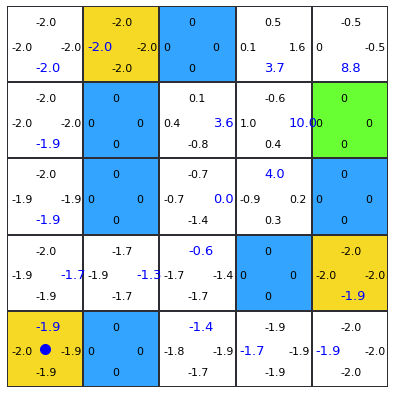

In [46]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)
    
discount_factor = 0.5
agent = modelFreeAgent(policy, discount_factor)
environment = GridEnvironment()

# MonteCarlo first visit.
ephocs = 1000
policy_control = PolicyControl(environment, agent, epsilon = 0.2, ephocs = ephocs, learning_rate = 0.5)
policy_control.sarsa_control(velocity = 0.01, plot_ephocs = False, plot_evaluation = False)
policy_control.render()

In [47]:
# Agent optimal policy.
agent.policy

[['up', 'right', 'down', 'down', 'down'],
 ['r', 'right', 'r', 'r', 'left'],
 ['up', 'up', 'right', 'right', 'r'],
 ['left', 'r', 'up', 'right', 'down'],
 ['left', 'down', 'r', 'r', 'down']]

### 2.2 Q-learning algorithm (Off-policy).

---
<img src = "./imagenes/qlearning_control_preview_algorithm.png" width = "600px" >

---
<img src = "./imagenes/qlearning_control_algorithm.png" width = "500px">

In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [2]:
class Graphics():
    
    def __init__(self):
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]
        
    def render(self, position, q_value_table, plot_values = True):
            
        fig1 = plt.figure(figsize=(7, 7))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

         # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.2, 0.8), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))
        
        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.4), 0.2, 0.2, facecolor = "#33A4FF"))
        
        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot player.
        plt.scatter(self.grid_pos[position[0]], self.grid_pos[position[1]], s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        if plot_values:
            for i in range(0, len(q_value_table)):
                for j in range(0, len(q_value_table)):
                    
                    colors = ["black", "black", "black", "black"]
                    fontsize_ = [11, 11, 11, 11]
                    
                    q_values = list()
                    for action in range(0, 4):
                        q_values.append(q_value_table[i][j][action])
                    if not q_values == [0, 0, 0 ,0]:
                        best_q = max(q_values)
                        best_q = q_values.index(best_q)
                        colors[best_q] = "blue"
                        fontsize_[best_q] = 13
                 
                    # Up, bottom, left, right.
                    plt.text(i/5 + 0.075, j/5 + 0.15, round(q_value_table[i][j][0], 1), fontsize=fontsize_[0], c = colors[0])
                    plt.text(i/5 + 0.075, j/5 + 0.03, round(q_value_table[i][j][1], 1), fontsize=fontsize_[1], c = colors[1])
                    plt.text(i/5 + 0.01, j/5 + 0.085, round(q_value_table[i][j][2], 1), fontsize=fontsize_[2], c = colors[2])
                    plt.text(i/5 + 0.14, j/5 + 0.085, round(q_value_table[i][j][3], 1), fontsize=fontsize_[3], c = colors[3])
                
        # Plot grid.
        plt.axis("off")
        plt.show()  

In [3]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1]]
        self.rewards = [[self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, 10, self.rw]]

In [4]:
class modelFreeAgent():
    
    def __init__(self, policy, discount_factor):
        self.pos = [0,0]
        self.total_reward = 0
        self.discount_factor = discount_factor
        self.actions = ["up", "down", "left", "right"]
        
        # Start with a random policy. 0.25 chance of moving to any direction.
        self.policy = policy   
        
    # Move!
    def move(self, action, environment):
        # Move to new position according to action taken.
        self.pos = self.forwardState(self.pos, action, environment)
        
    # Take an action!
    def takeAction(self, epsilon):
        
        # Select action according to policy.
        action = self.policy[self.pos[0]][self.pos[1]]
        if action == "r":
            action = self.actions[random.randint(0, 3)]
        else:
            # Epsilon-greedy policy!
            num = random.randint(1, 100)
            if not num < (1 - epsilon + epsilon/len(self.actions)) * 100:
                action = self.actions[random.randint(0, 3)]
        return action
        
    # Get forward state.
    def forwardState(self, pos, action, environment):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(environment.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]
        elif(action == "down" and pos[1] > 0):
            if(environment.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]
        elif(action == "left" and pos[0] > 0):
            if(environment.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]
        elif(action == "right" and pos[0] < 4):
            if(environment.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position
    
    def getPosition(self):
        return self.pos.copy()
    
    def getReward(self):
        return self.total_reward
    
    def setPosition(self, x, y):
        self.pos = [x, y]
        
    def selectBestAction(self, pos, q_value_table):
        
        q_values = list()
        for action in range(0, 4):
            q_values.append(q_value_table[pos[0]][pos[1]][action])
        best_q = max(q_values)
        best_q = q_values.index(best_q)
        best_action = self.actions[best_q] 
        return best_action       

In [5]:
class PolicyControl():
    
    # Initialize policy control object.
    def __init__(self, environment, agent, epsilon = 0.2, ephocs = 10, learning_rate = 0.5):
        
        # Print message!
        print("Policy Control Initialize!")
        
        # Initialize environment & agent.
        self.environment = environment       
        self.agent = agent     
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        
        # Set ephocs and initialize graphics object.
        self.ephocs = ephocs
        self.graphics = Graphics()
        
        # Generate Q value table.
        self.q_value_table = list()
        for i in range(0, 5):
            column = list()
            for j in range(0, 5):
                column.append([0, 0, 0, 0])
            self.q_value_table.append(column)
       
    # Process Input.
    def processInput(self, action): 
        if action == "w": return "up"
        elif action == "d": return "right"
        elif action == "s": return "down"
        elif action == "a": return "left"
        else: return "up"
                   
    # Montecarlo control algorithm.
    def q_learning_control(self):

        # Repeat k ephocs.
        for k in range(0, self.ephocs):
            
            self.render()
            
            # Continue until get to the terminal state.
            while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
                
                # Current position.   
                current_pos = self.agent.pos.copy()                                           # S
                
                # Select action according to greedy policy (epsilon = 0)
                action = self.processInput(input("Digite una tecla: "))                       # A
                forward_state = self.agent.forwardState(current_pos, action, self.environment)
            
                # Get reward.
                reward_recieved = self.environment.rewards[forward_state[0]][forward_state[1]] # R
                
                # Move agent.                                                                
                self.agent.move(action, self.environment)                                     # S'
                
                # Render game.
                clear_output(wait = True)
                self.render()
                                
                # Get best action
                agent_best_action = self.agent.selectBestAction(self.agent.pos, self.q_value_table) # A'  

                # Get Q-values from table.
                z_index = self.agent.actions.index(action)
                q_value_sa = self.q_value_table[current_pos[0]][current_pos[1]][z_index]
                z_index_prime = self.agent.actions.index(agent_best_action)
                q_value_sa_prime = self.q_value_table[self.agent.pos[0]][self.agent.pos[1]][z_index_prime]
                
                # Get SARA target.
                Q_target = reward_recieved + self.agent.discount_factor * q_value_sa_prime

                # Compute SARSA error.
                Q_error = Q_target - q_value_sa

                # Update Q-value table.
                self.q_value_table[current_pos[0]][current_pos[1]][z_index] += self.learning_rate * (Q_error)

                # Update e-greedy policy???
                self.update_egreedy_policy(current_pos[0], current_pos[1])
                
            # Change agent position.
            positions = [(0,0), (4, 1), (1, 4)]
            pos = positions[k % 3]
            self.agent.setPosition(pos[0], pos[1])
            
            # Clear output.
            clear_output(wait = True)
                
    def render(self):
        self.graphics.render(self.agent.pos, self.q_value_table)
    
    # Update egreedy policy.
    def update_egreedy_policy(self, x, y):
        q_values = list()
        for action in range(0, 4):
            q_values.append(self.q_value_table[x][y][action])
        if not q_values == [0, 0, 0, 0]:
            
            # Epsilon-greedy improvement.
            num = random.randint(1, 100)
            if not num < (1 - self.epsilon + self.epsilon/len(self.agent.actions)) * 100:
                q_values.remove(max(q_values))
                action = self.agent.actions[q_values.index(random.choice(q_values))]
            else:
                best_q = max(q_values)
                best_q = q_values.index(best_q)
                self.agent.policy[x][y] = self.agent.actions[best_q]

In [6]:
class Game():
    
    def __init__(self, environment, agent, q_value_table):
        
        self.environment = environment       
        self.agent = agent
        self.graphics = Graphics()
        self.table = q_value_table
        
    def update(self, plot_values = False):
        
        pos = self.agent.getPosition()
        self.graphics.render(pos, self.table, plot_values)
        time.sleep(1)
        clear_output(wait = True)
        
        while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
            
            # Select action according to greedy policy (epsilon = 0)
            action = self.processInput(input("Digite una tecla: "))

            # Move agent.
            self.agent.move(action, self.environment)
            
            # Get new agent position.
            pos = self.agent.getPosition()
            
            # Render game.
            self.graphics.render(pos, self.table, plot_values)
            #time.sleep(secs)
            clear_output(wait = True)
            
    def processInput(self, action): 
        if action == "w": return "up"
        elif action == "d": return "right"
        elif action == "s": return "down"
        elif action == "a": return "left"
        else: return "up"

In [10]:
class Game():
    
    def __init__(self, environment, agent, q_value_table):
        
        self.environment = environment       
        self.agent = agent
        self.graphics = Graphics()
        self.table = q_value_table
        
    def update(self, secs, plot_values = False):
        
        pos = self.agent.getPosition()
        self.graphics.render(pos, self.table, plot_values)
        time.sleep(1)
        clear_output(wait = True)
        
        while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
            
            # Select action according to greedy policy (epsilon = 0)
            action = self.agent.takeAction(epsilon = 0.05)
            
            # Move agent.
            self.agent.move(action, self.environment)
            
            # Get new agent position.
            pos = self.agent.getPosition()
            
            # Render game.
            self.graphics.render(pos, self.table, plot_values)
            time.sleep(secs)
            clear_output(wait = True)

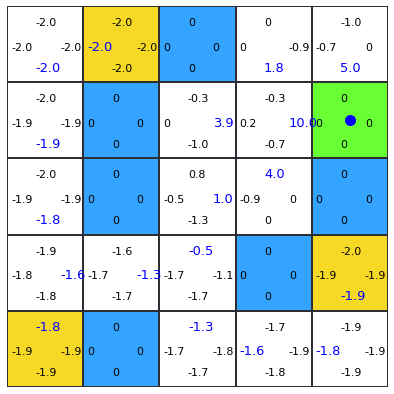

In [7]:
### Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)
    
discount_factor = 0.5
agent = modelFreeAgent(policy, discount_factor)
environment = GridEnvironment()

policy_control = PolicyControl(environment, agent, epsilon = 0.2, ephocs = 30, learning_rate = 0.5)
policy_control.q_learning_control()

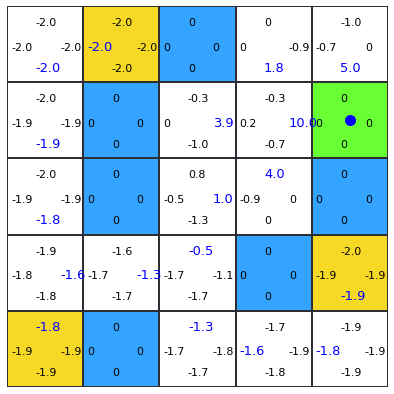

In [13]:
agent.setPosition(4, 1)
game = Game(environment, agent, policy_control.q_value_table)
game.update(secs = 0.1, plot_values = True)

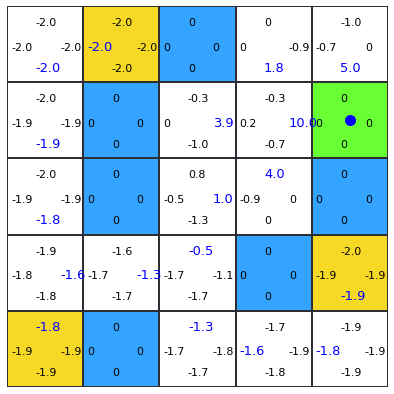

In [14]:
agent.setPosition(1, 4)
game = Game(environment, agent, policy_control.q_value_table)
game.update(secs = 0.1, plot_values = True)

In [ ]:
agent.setPosition(0, 0)
game = Game(environment, agent, policy_control.q_value_table)
game.update(secs = 0.1, plot_values = True)